In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
# Load the datasets
training_data_path = '/content/drive/MyDrive/twitter_training.csv'
validation_data_path = '/content/drive/MyDrive/twitter_validation.csv'

In [ ]:
# Read the datasets
training_df = pd.read_csv(training_data_path, encoding='latin1')
validation_df = pd.read_csv(validation_data_path, encoding='latin1')

In [ ]:
# Rename columns for easier reference
training_df.columns = ['ID', 'Category', 'Sentiment', 'Tweet']
validation_df.columns = ['ID', 'Category', 'Sentiment', 'Tweet']

In [ ]:
# Handle missing values
training_df.dropna(subset=['Tweet'], inplace=True)
validation_df.dropna(subset=['Tweet'], inplace=True)

In [ ]:
# Function to clean tweet text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # Remove @ and #
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove digits
    return text

In [ ]:
# Apply cleaning function to both datasets
training_df['Cleaned_Tweet'] = training_df['Tweet'].apply(clean_text)
validation_df['Cleaned_Tweet'] = validation_df['Tweet'].apply(clean_text)

In [ ]:
# Exploratory Data Analysis (EDA)
def eda(df, title):
    print(f"\nEDA for {title}\n")
    print("Data Info:")
    print(df.info())
    print("\nFirst few rows:")
    print(df.head())
    print("\nBasic Statistics:")
    print(df.describe(include='all'))
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nCategory Distribution:")
    print(df['Category'].value_counts())
    print("\nSentiment Distribution:")
    print(df['Sentiment'].value_counts())
    print("\nTweet Length Distribution:")
    df['Tweet_Length'] = df['Cleaned_Tweet'].apply(len)
    print(df['Tweet_Length'].describe())

    plt.figure(figsize=(10, 6))
    sns.histplot(df['Tweet_Length'], kde=True)
    plt.title(f'Tweet Length Distribution in {title}')
    plt.xlabel('Tweet Length')
    plt.ylabel('Frequency')
    plt.show()



EDA for Training Data

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 73995 entries, 0 to 74680
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             73995 non-null  int64 
 1   Category       73995 non-null  object
 2   Sentiment      73995 non-null  object
 3   Tweet          73995 non-null  object
 4   Cleaned_Tweet  73995 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB
None

First few rows:
     ID     Category Sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                               Tweet  \
0  I am coming to the borders and I will kill you...   
1  im getting on borderlands and i will kill you ...   
2  im coming on borderlands and i will murder you...   
3  im getting on borderlands 2 and i will murder ...   
4  i

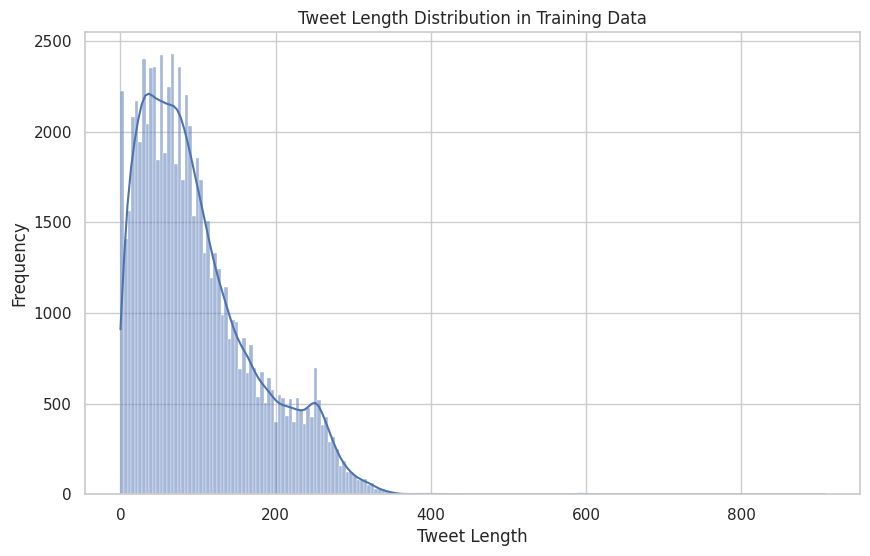


EDA for Validation Data

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             999 non-null    int64 
 1   Category       999 non-null    object
 2   Sentiment      999 non-null    object
 3   Tweet          999 non-null    object
 4   Cleaned_Tweet  999 non-null    object
dtypes: int64(1), object(4)
memory usage: 39.1+ KB
None

First few rows:
     ID   Category Sentiment  \
0   352     Amazon   Neutral   
1  8312  Microsoft  Negative   
2  4371      CS-GO  Negative   
3  4433     Google   Neutral   
4  6273       FIFA  Negative   

                                               Tweet  \
0  BBC News - Amazon boss Jeff Bezos rejects clai...   
1  @Microsoft Why do I pay for WORD when it funct...   
2  CSGO matchmaking is so full of closet hacking,...   
3  Now the President is slapping Americans in the...   
4  Hi @EAHel

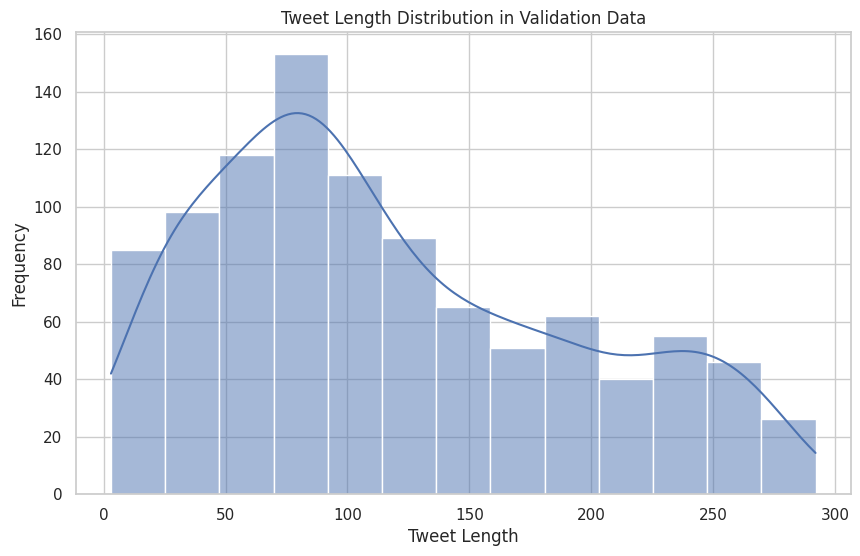

In [ ]:
eda(training_df, "Training Data")
eda(validation_df, "Validation Data")

In [ ]:
# Word Clouds for each sentiment
def generate_wordclouds(df, title):
    sentiments = df['Sentiment'].unique()
    for sentiment in sentiments:
        text = ' '.join(df[df['Sentiment'] == sentiment]['Cleaned_Tweet'])
        wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(text)
        plt.figure(figsize=(10, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {sentiment} Sentiment in {title}')
        plt.show()

generate_wordclouds(training_df, "Training Data")
generate_wordclouds(validation_df, "Validation Data")


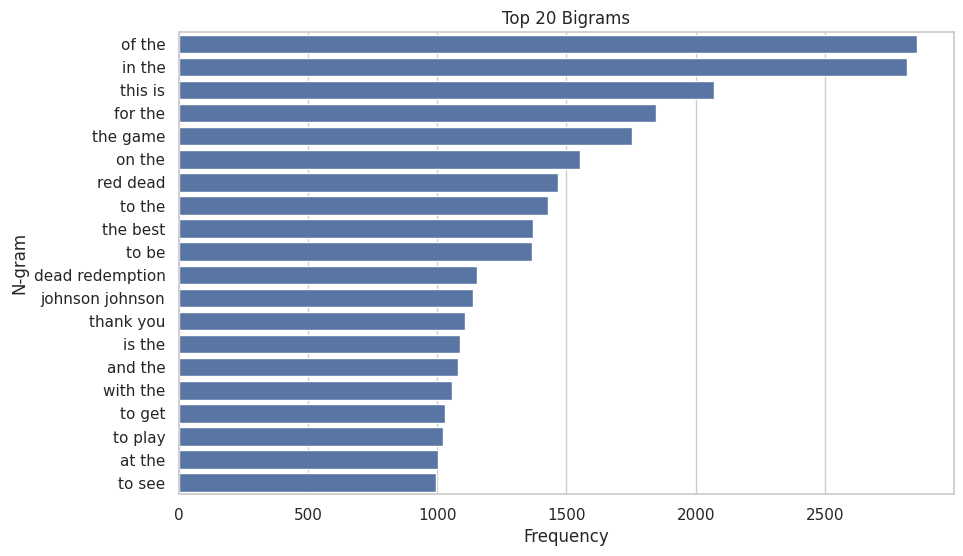

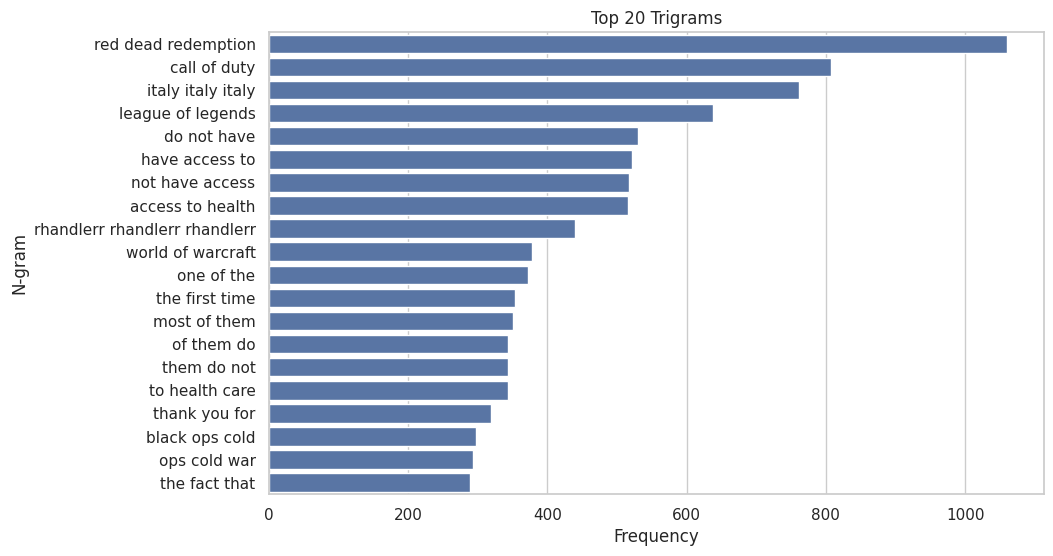

In [ ]:
# Bigram and Trigram Analysis
def plot_ngrams(corpus, ngram_range=(2, 2), n=None, title="N-grams"):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_df = pd.DataFrame(words_freq[:n], columns=['N-gram', 'Frequency'])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frequency', y='N-gram', data=words_df)
    plt.title(title)
    plt.show()

corpus = training_df['Cleaned_Tweet'].tolist()
plot_ngrams(corpus, ngram_range=(2, 2), n=20, title="Top 20 Bigrams")
plot_ngrams(corpus, ngram_range=(3, 3), n=20, title="Top 20 Trigrams")


In [ ]:
# Sentiment by User
def sentiment_by_user(df, title):
    user_sentiment = df.groupby(['User', 'Sentiment']).size().unstack(fill_value=0)
    user_sentiment.plot(kind='bar', stacked=True, figsize=(14, 7), title=f'Sentiment by User in {title}')
    plt.xlabel('User')
    plt.ylabel('Number of Tweets')
    plt.legend(title='Sentiment')
    plt.show()


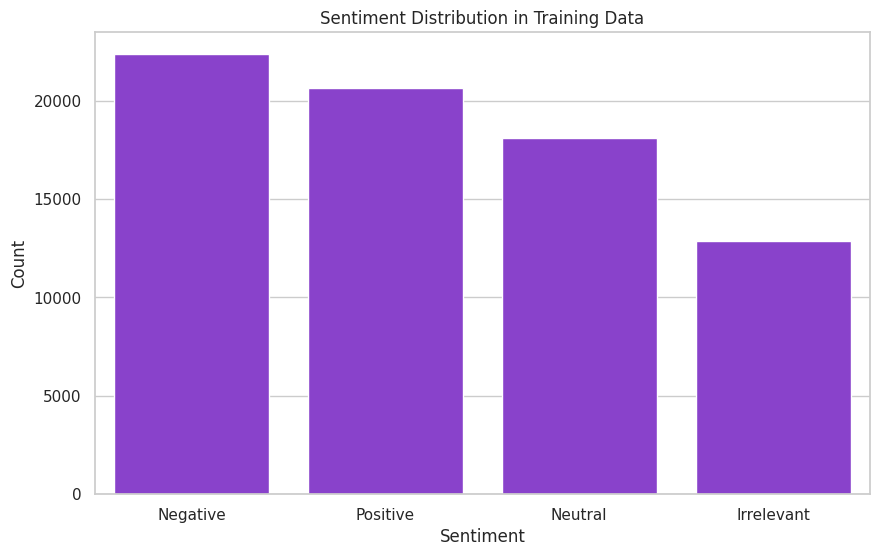

In [ ]:
# Sentiment Distribution - Training Data
plt.figure(figsize=(10, 6))
sns.countplot(data=training_df, x='Sentiment', order=training_df['Sentiment'].value_counts().index,color='blueviolet')
plt.title('Sentiment Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

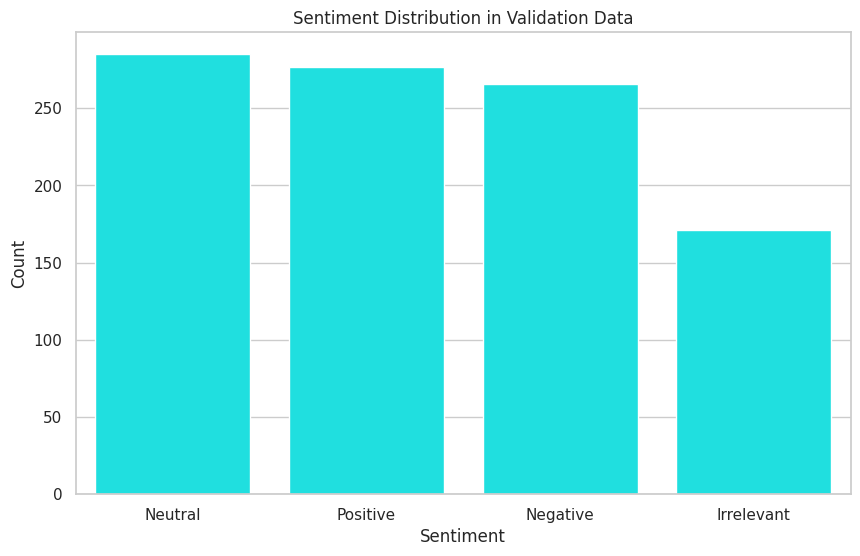

In [ ]:
# Sentiment Distribution - Validation Data
plt.figure(figsize=(10, 6))
sns.countplot(data=validation_df, x='Sentiment', order=validation_df['Sentiment'].value_counts().index,color='cyan')
plt.title('Sentiment Distribution in Validation Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

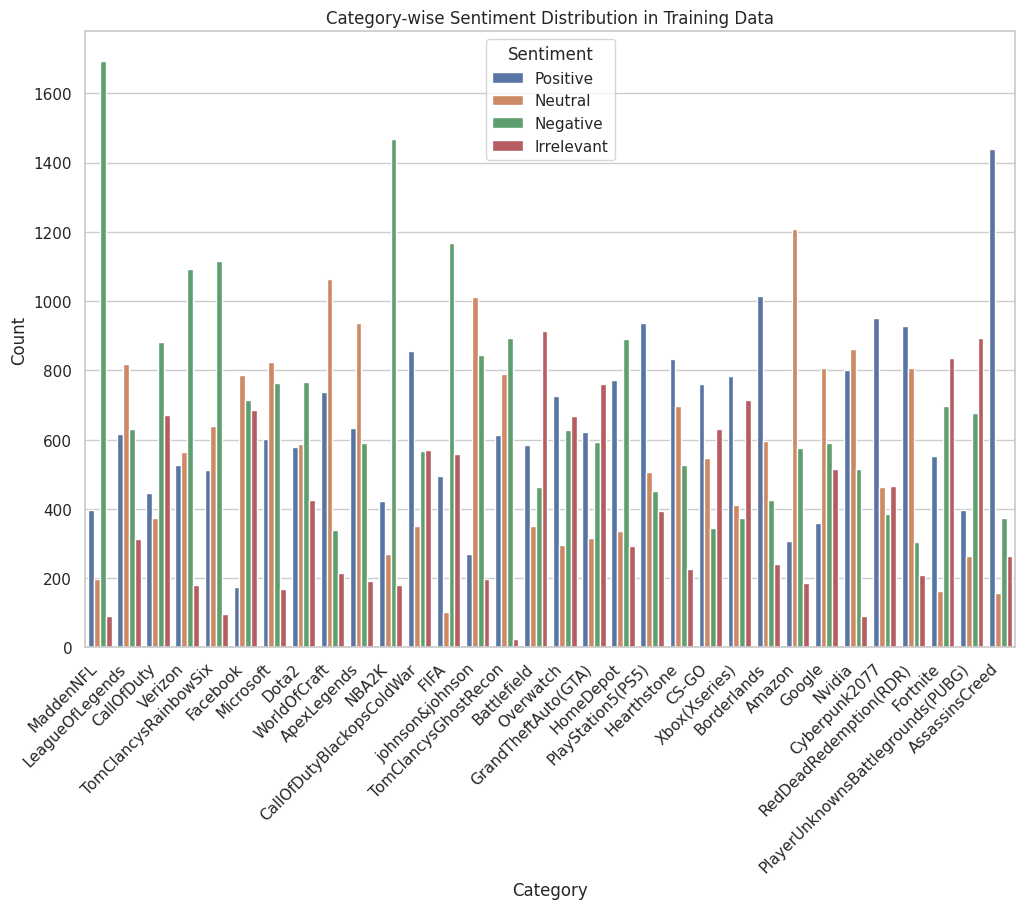

In [ ]:
# Category-wise Sentiment Distribution - Training Data
plt.figure(figsize=(12, 8))
sns.countplot(data=training_df, x='Category', hue='Sentiment', order=training_df['Category'].value_counts().index)
plt.title('Category-wise Sentiment Distribution in Training Data')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.show()

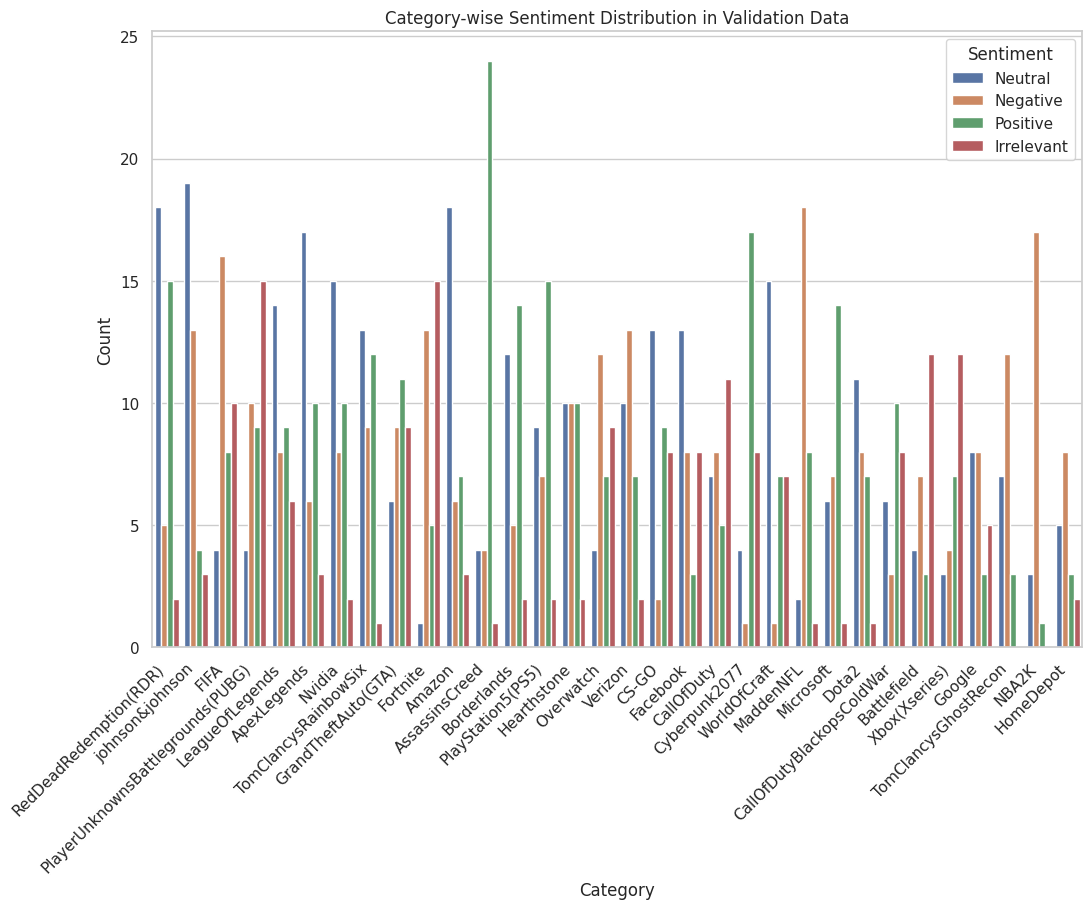

In [ ]:
# Category-wise Sentiment Distribution - Validation Data
plt.figure(figsize=(12, 8))
sns.countplot(data=validation_df, x='Category', hue='Sentiment', order=validation_df['Category'].value_counts().index)
plt.title('Category-wise Sentiment Distribution in Validation Data')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.show()